In [0]:
# install all the require package
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [0]:
# Mounnt Google Drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [0]:
import os
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Catboost Specific
import catboost
print(catboost.__version__)

0.23


In [0]:
main_path = r'/content/drive/My Drive/Insurance_Churn_ParticipantsData'

for files in os.listdir(main_path):
  files_paths = os.path.join(main_path,files)
  print(files_paths)

/content/drive/My Drive/Insurance_Churn_ParticipantsData/sample_submission.xlsx
/content/drive/My Drive/Insurance_Churn_ParticipantsData/Train.csv
/content/drive/My Drive/Insurance_Churn_ParticipantsData/Test.csv
/content/drive/My Drive/Insurance_Churn_ParticipantsData/grid_model.pkl


In [0]:
# Below function reduce the memory usage it basically converts the high datatype to lower without loosing on the data
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
# Function to make plots
def make_plots(col):
    train_df.loc[train_df.labels==1].groupby(col)['labels'].sum().plot(kind='bar')
    plt.plot()

In [0]:
from sklearn.metrics import (accuracy_score,roc_auc_score,log_loss,precision_score,recall_score,f1_score,confusion_matrix,classification_report)
# Creating a function to return all the measures
def calculate_measure(actual,predicted):
  print('Accuracy Score={0}'.format(accuracy_score(actual,predicted)))
  print('AUC ROC Score={}'.format(roc_auc_score(actual,predicted)))
  print('F1 Score={}'.format(f1_score(actual,predicted)))
  print('Precison Score={}'.format(precision_score(actual,predicted)))
  print('Recall Score={}'.format(recall_score(actual,predicted)))
  print('Log Loss Score={}'.format(log_loss(actual,predicted)))

  conf_matrix = confusion_matrix(actual,predicted)
  TN = conf_matrix[0,0]
  TP = conf_matrix[1,0]
  FP = conf_matrix[0,1]
  FN = conf_matrix[1,1]

  print('Confusion Metric Scores: TN={0},TP={1},FP={2},FN={3}\n'.format(TN,TP,FP,FN))
  print('CLassification Report')
  print(classification_report(actual,predicted))

In [0]:
train_df = pd.read_csv('/content/drive/My Drive/Insurance_Churn_ParticipantsData/Train.csv',encoding="utf-8")
train_df = reduce_mem_usage(train_df)
test_df = pd.read_csv('/content/drive/My Drive/Insurance_Churn_ParticipantsData/Test.csv',encoding="utf-8")
test_df = reduce_mem_usage(test_df)
sample_df = pd.read_excel('/content/drive/My Drive/Insurance_Churn_ParticipantsData/sample_submission.xlsx')
sample_df = reduce_mem_usage(sample_df)

Memory usage of dataframe is 4.40 MB --> 1.23 MB (Decreased by 72.1%)
Memory usage of dataframe is 1.38 MB --> 0.40 MB (Decreased by 71.1%)
Memory usage of dataframe is 0.09 MB --> 0.01 MB (Decreased by 87.4%)


In [0]:
# Checking the data present in the train dataset
train_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,labels
0,-0.276515,-0.424429,1.344997,-0.012283,0.076230,1.076648,0.182198,3,0,1,0,0,0,0,10,2,1
1,0.853573,0.150991,0.503892,-0.979179,-0.569351,-0.411453,-0.251940,4,1,2,0,1,0,0,0,3,0
2,0.947747,-0.173832,1.825628,-0.703478,0.076230,-0.411453,-0.251940,6,1,2,0,0,0,0,5,3,0
3,0.853573,-0.381404,0.984523,-0.039464,-0.569351,-0.411453,-0.251940,4,0,2,0,1,0,0,5,3,0
4,1.324443,1.590527,-1.178319,-0.097711,-0.246560,-0.411453,-0.251940,0,1,1,0,0,0,0,8,3,0


In [0]:
# Checking the data for test dataset
test_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
0,0.571051,0.406843,0.984523,0.011016,-0.569351,-0.411453,-0.251940,0,1,1,0,0,0,0,11,3
1,-1.124080,-0.166935,0.503892,-0.322932,0.721811,0.547323,0.182198,0,2,1,0,0,0,0,5,1
2,0.476877,0.145079,-0.577529,-0.691828,-0.246560,-0.411453,-0.251940,0,1,1,0,0,0,0,1,3
3,1.606965,-0.447419,1.825628,-0.983062,7.177616,-0.411453,-0.251940,1,1,0,0,1,0,0,5,3
4,-0.935732,-0.364653,-1.178319,-0.322932,0.076230,-0.411453,-0.251940,8,2,1,0,1,0,2,8,3


In [0]:
# Checking the sample for submission
sample_df.head()

,labels
0,1
1,1
2,1
3,1
4,1


In [0]:
# Checking the columns present in the dataset
train_df.columns

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'labels'],
      dtype='object')

In [0]:
# Below columns looks like catagorical in nature
cat_cols = list(train_df.columns[7:16])
for cols in cat_cols:
  print('For column {0} the counts are {1}'.format(cols,train_df[cols].value_counts().index.max()))

For column feature_7 the counts are 11
For column feature_8 the counts are 2
For column feature_9 the counts are 3
For column feature_10 the counts are 1
For column feature_11 the counts are 1
For column feature_12 the counts are 1
For column feature_13 the counts are 2
For column feature_14 the counts are 11
For column feature_15 the counts are 3


In [0]:
# Cheking for the class imbalence
print(np.unique(train_df.labels,return_counts=True))

100*round(train_df.labels.value_counts()/len(train_df.index),2)

(array([0, 1], dtype=int8), array([29941,  3967]))


0    88.0
1    12.0
Name: labels, dtype: float64

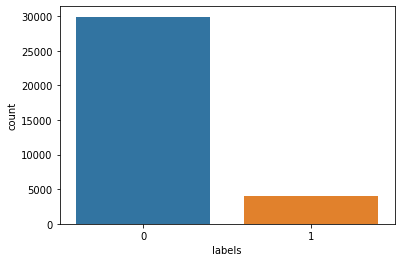

In [0]:
# We can see that there is a huge class imbalence
sns.countplot(train_df.labels)

In [0]:
# Lets check some statistics about the dataset
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
feature_0,33908.0,-0.004158,0.999800,-2.159994,-0.747384,-0.182341,0.665225,5.091402
feature_1,33908.0,0.002584,1.014276,-3.081149,-0.422787,-0.297324,0.022901,33.094776
feature_2,33908.0,-0.000213,1.000878,-1.779108,-0.938003,0.023260,0.624050,1.825628
feature_3,33908.0,-0.000053,1.002506,-1.002478,-0.602517,-0.303517,0.236237,18.094700
feature_4,33908.0,-0.000298,1.003785,-0.569351,-0.569351,-0.246560,0.076230,19.443647
feature_5,33908.0,-0.004652,0.994042,-0.411453,-0.411453,-0.411453,-0.411453,8.127647
feature_6,33908.0,-0.007497,0.802753,-0.251940,-0.251940,-0.251940,-0.251940,23.625645
feature_7,33908.0,4.336381,3.273376,0.000000,1.000000,4.000000,7.000000,11.000000
feature_8,33908.0,1.171051,0.606730,0.000000,1.000000,1.000000,2.000000,2.000000
feature_9,33908.0,1.225345,0.749104,0.000000,1.000000,1.000000,2.000000,3.000000


In [0]:
# lets check the amount of nulls present in the dataset
train_df.isnull().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
labels        0
dtype: int64

In [0]:
test_df.isnull().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
dtype: int64

In [0]:
# We can see that both train and test dataset donot have any null values

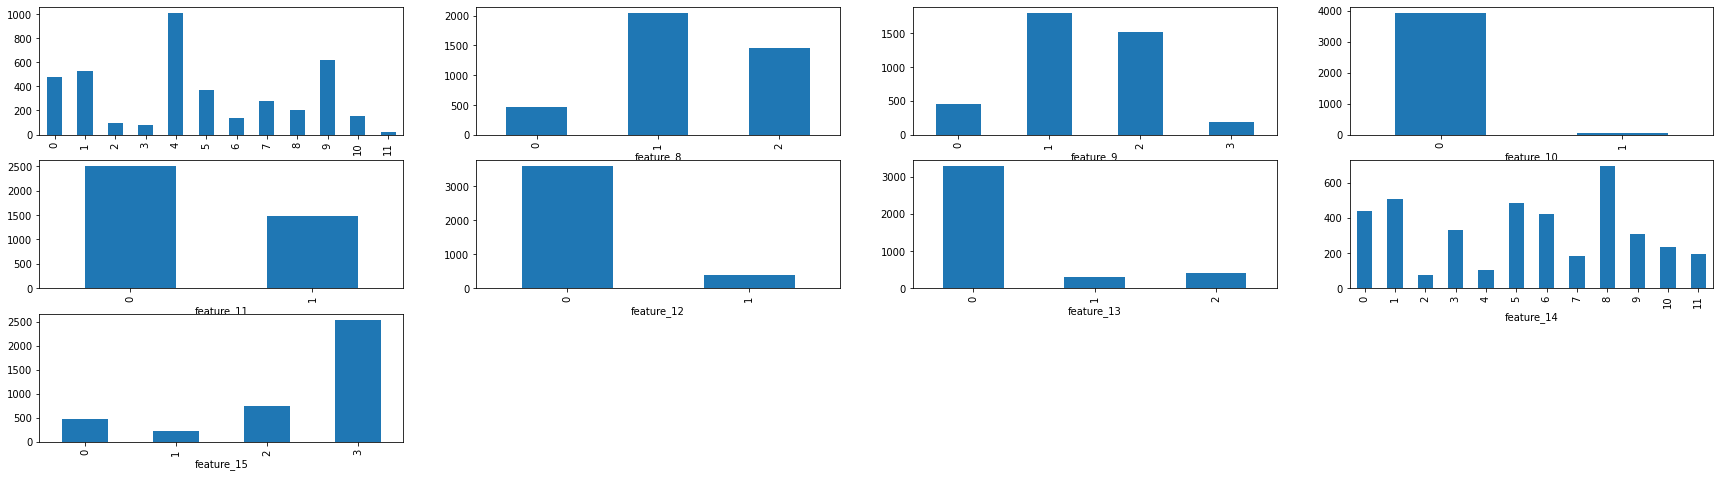

In [0]:
cat_cols = list(train_df.columns[7:16])
plt.figure(figsize=(30,8))
for ind,col in enumerate(cat_cols):
  plt.subplot(3,4,ind+1)
  make_plots(train_df[col])
plt.show()

In [0]:
train_data,validation_data = train_test_split(train_df,test_size=0.3,random_state=1001)

In [0]:
y_train_data = train_data.labels
X_train_data = train_data.drop('labels',axis=1)

y_validation_data = validation_data.labels
X_validation_data = validation_data.drop('labels',axis=1)

In [0]:
X_train_data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15
5159,1.795313,0.722799,-0.337213,-0.385062,-0.246560,-0.411453,-0.25194,1,1,3,0,0,0,0,1,3
12724,-0.841558,0.889644,1.705471,0.236237,-0.246560,-0.411453,-0.25194,9,2,2,0,0,0,0,6,3
5345,1.795313,-0.492415,0.744208,-0.412244,-0.569351,-0.411453,-0.25194,5,0,0,0,1,0,0,5,3
20243,-1.124080,-0.310461,1.465155,-0.093828,2.658552,-0.411453,-0.25194,7,1,1,0,1,0,0,5,3
4736,2.737053,3.919796,-1.658950,1.245848,-0.246560,-0.411453,-0.25194,4,1,2,0,0,0,0,3,3


In [0]:
cat_features = list(range(7, X_train_data.shape[1]))
print(cat_features)

[7, 8, 9, 10, 11, 12, 13, 14, 15]


In [0]:
# Base Model without tuning
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=1000)
model.fit(X_train_data, y_train_data, cat_features=cat_features, verbose=10,)

Learning rate set to 0.039831
0:	learn: 0.6416876	total: 95.6ms	remaining: 1m 35s
10:	learn: 0.3842699	total: 464ms	remaining: 41.8s
20:	learn: 0.2938365	total: 811ms	remaining: 37.8s
30:	learn: 0.2538712	total: 1.17s	remaining: 36.6s
40:	learn: 0.2332809	total: 1.51s	remaining: 35.4s
50:	learn: 0.2217731	total: 1.9s	remaining: 35.4s
60:	learn: 0.2156584	total: 2.26s	remaining: 34.8s
70:	learn: 0.2112749	total: 2.63s	remaining: 34.4s
80:	learn: 0.2083622	total: 3s	remaining: 34s
90:	learn: 0.2061684	total: 3.37s	remaining: 33.7s
100:	learn: 0.2036318	total: 3.73s	remaining: 33.2s
110:	learn: 0.2016211	total: 4.11s	remaining: 32.9s
120:	learn: 0.2000628	total: 4.48s	remaining: 32.5s
130:	learn: 0.1984112	total: 4.84s	remaining: 32.1s
140:	learn: 0.1969052	total: 5.19s	remaining: 31.6s
150:	learn: 0.1955659	total: 5.55s	remaining: 31.2s
160:	learn: 0.1942640	total: 5.92s	remaining: 30.8s
170:	learn: 0.1932949	total: 6.28s	remaining: 30.4s
180:	learn: 0.1923286	total: 6.63s	remaining: 30s

In [0]:
prediction = model.predict(X_validation_data)
calculate_measure(y_validation_data,prediction)

Accuracy Score=0.9094662341492186
AUC ROC Score=0.726822331715093
F1 Score=0.5633001422475107
Precison Score=0.668918918918919
Recall Score=0.4864864864864865
Log Loss Score=3.1269486032986555
Confusion Metric Scores: TN=8658,TP=627,FP=294,FN=594

CLassification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      8952
           1       0.67      0.49      0.56      1221

    accuracy                           0.91     10173
   macro avg       0.80      0.73      0.76     10173
weighted avg       0.90      0.91      0.90     10173



In [0]:
prediction_test = model.predict(test_df)

In [0]:
submit_excel = pd.DataFrame(prediction_test,columns=['labels'])
submit_excel.to_excel('submission.xlsx')
from google.colab import files
files.download('submission.xlsx')

In [0]:
# Using Pool Class for passing Dataset for the Model becasue pool is helpful when dataset is big
from catboost import Pool

train_pool = Pool(
    data = X_train_data  ,
    label = y_train_data ,
    cat_features=cat_features
)


validation_pool = Pool(
    data = X_validation_data   ,
    label = y_validation_data  ,
    cat_features=cat_features
)

In [0]:
# Using Cross Validation on the dataset
from catboost import cv

params = {
    'loss_function': 'Logloss',
    'iterations': 1000,
    'custom_loss': 'AUC',
    'learning_rate': 0.5,
}


cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

best_value = cv_data['test-Logloss-mean'].min()
best_iter = cv_data['test-Logloss-mean'].values.argmin()

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [0]:
# Using GridSearch for finding the best parameters

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt    
from sklearn.model_selection import GridSearchCV
param_grid = {'depth':[2, 3, 4],
              'loss_function': ['Logloss', 'CrossEntropy'],
              'l2_leaf_reg':np.logspace(-20, -19, 3)
             }

clf = CatBoostClassifier(iterations=2500,
                            loss_function = param_grid['loss_function'],
                            depth=param_grid['depth'],
                            l2_leaf_reg = param_grid['l2_leaf_reg'],
                            eval_metric = 'Accuracy',
                            leaf_estimation_iterations = 10,
                            use_best_model=True,
                            task_type="GPU"
                            
                         )
grid_search = GridSearchCV(clf, param_grid=param_grid, cv = 5, n_jobs=-1,verbose=2)
results = grid_search.fit(X_train_data, y_train_data,eval_set=(X_validation_data,y_validation_data))
results.best_estimator_.get_params()

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 42.9min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 106.3min finished


0:	learn: 0.8950916	test: 0.8890200	best: 0.8890200 (0)	total: 51.9ms	remaining: 2m 9s
1:	learn: 0.8874658	test: 0.8850880	best: 0.8890200 (0)	total: 98.3ms	remaining: 2m 2s
2:	learn: 0.8870023	test: 0.8843999	best: 0.8890200 (0)	total: 146ms	remaining: 2m 1s
3:	learn: 0.8870023	test: 0.8846948	best: 0.8890200 (0)	total: 193ms	remaining: 2m
4:	learn: 0.8870023	test: 0.8846948	best: 0.8890200 (0)	total: 224ms	remaining: 1m 51s
5:	learn: 0.8872130	test: 0.8845965	best: 0.8890200 (0)	total: 248ms	remaining: 1m 43s
6:	learn: 0.8870444	test: 0.8845965	best: 0.8890200 (0)	total: 280ms	remaining: 1m 39s
7:	learn: 0.8870866	test: 0.8843016	best: 0.8890200 (0)	total: 305ms	remaining: 1m 34s
8:	learn: 0.8869181	test: 0.8832203	best: 0.8890200 (0)	total: 327ms	remaining: 1m 30s
9:	learn: 0.8870444	test: 0.8831220	best: 0.8890200 (0)	total: 349ms	remaining: 1m 26s
10:	learn: 0.8870444	test: 0.8837118	best: 0.8890200 (0)	total: 371ms	remaining: 1m 23s
11:	learn: 0.8870866	test: 0.8841050	best: 0.88

{'depth': 3,
 'eval_metric': 'Accuracy',
 'iterations': 2500,
 'l2_leaf_reg': 1e-19,
 'leaf_estimation_iterations': 10,
 'loss_function': 'CrossEntropy',
 'task_type': 'GPU',
 'use_best_model': True}

In [0]:
est_dict = grid_search.best_params_
print(est_dict)

{'depth': 3, 'l2_leaf_reg': 1e-19, 'loss_function': 'CrossEntropy'}


In [0]:
grid_model = grid_search.best_estimator_

In [0]:
!pip install pickle-mixin

  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-cp36-none-any.whl size=5998 sha256=61ac8291205d8b0be6ded8c781c662adc5b5296194acb2fd215fd47d6bcfe30a
  Stored in directory: /root/.cache/pip/wheels/cd/05/42/71de70fa36b9cbb7657bb5793a16f8028c1cdc1bdd3b8e1ac3
Successfully built pickle-mixin


In [0]:
import pickle 

In [0]:
pickle.dump(grid_model,open('/content/drive/My Drive/Insurance_Churn_ParticipantsData/grid_model.pkl','wb'))

In [0]:
grid_model = pickle.load(open('/content/drive/My Drive/Insurance_Churn_ParticipantsData/grid_model.pkl','rb'))

In [0]:
prediction = grid_model.predict(X_validation_data)
calculate_measure(y_validation_data,prediction)

Accuracy Score=0.9077951440086504
AUC ROC Score=0.7028857702450195
F1 Score=0.530060120240481
Precison Score=0.6825806451612904
Recall Score=0.4332514332514332
Log Loss Score=3.184662239201224
Confusion Metric Scores: TN=8706,TP=692,FP=246,FN=529

CLassification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      8952
           1       0.68      0.43      0.53      1221

    accuracy                           0.91     10173
   macro avg       0.80      0.70      0.74     10173
weighted avg       0.90      0.91      0.90     10173



In [0]:
prediction_test = grid_model.predict(test_df)
submit_excel = pd.DataFrame(prediction_test,columns=['labels'])
submit_excel.to_excel('submission.xlsx')
from google.colab import files
files.download('submission.xlsx')

In [0]:
!pip install xgboost

In [0]:
# Now lets try StackingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


estimators = [('log_reg',LogisticRegression()),
              ('svm',SVC()),
              ('DecisionTreeClassifier',DecisionTreeClassifier()),
              ('RandomForestClassifier',RandomForestClassifier()),
              ('ExtraTreesClassifier',ExtraTreesClassifier()),
              ('AdaBoostClassifier',AdaBoostClassifier()),
              ('GradientBoostingClassifier',GradientBoostingClassifier()),
              ('XGBClassifier',XGBClassifier()),
              ('CatBoostClassifier',CatBoostClassifier())
              ]

clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_train_data, y_train_data).score(X_validation_data, y_validation_data)

Streaming output truncated to the last 5000 lines.
5:	learn: 0.4986380	total: 65.8ms	remaining: 10.9s
6:	learn: 0.4747003	total: 76.6ms	remaining: 10.9s
7:	learn: 0.4543994	total: 87.3ms	remaining: 10.8s
8:	learn: 0.4354546	total: 98.1ms	remaining: 10.8s
9:	learn: 0.4175658	total: 109ms	remaining: 10.8s
10:	learn: 0.4048148	total: 119ms	remaining: 10.7s
11:	learn: 0.3913128	total: 130ms	remaining: 10.7s
12:	learn: 0.3767662	total: 140ms	remaining: 10.6s
13:	learn: 0.3623365	total: 150ms	remaining: 10.6s
14:	learn: 0.3529056	total: 161ms	remaining: 10.6s
15:	learn: 0.3438552	total: 171ms	remaining: 10.5s
16:	learn: 0.3346646	total: 182ms	remaining: 10.5s
17:	learn: 0.3258949	total: 192ms	remaining: 10.5s
18:	learn: 0.3199138	total: 207ms	remaining: 10.7s
19:	learn: 0.3130859	total: 218ms	remaining: 10.7s
20:	learn: 0.3069456	total: 230ms	remaining: 10.7s
21:	learn: 0.3018724	total: 241ms	remaining: 10.7s
22:	learn: 0.2968468	total: 251ms	remaining: 10.7s
23:	learn: 0.2923323	total: 262m

0.9061240538680821

In [0]:
prediction = clf.predict(X_validation_data)
calculate_measure(y_validation_data,prediction)

Accuracy Score=0.9061240538680821
AUC ROC Score=0.7139602586988647
F1 Score=0.5410860163382988
Precison Score=0.6546511627906977
Recall Score=0.4610974610974611
Log Loss Score=3.242383656500194
Confusion Metric Scores: TN=8655,TP=658,FP=297,FN=563

CLassification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      8952
           1       0.65      0.46      0.54      1221

    accuracy                           0.91     10173
   macro avg       0.79      0.71      0.74     10173
weighted avg       0.90      0.91      0.90     10173



In [0]:
print('#'*200)

########################################################################################################################################################################################################


In [0]:
# Next Section lets try to manually handle feature

In [0]:
cols = ['feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15']
X_train_data[cols] = X_train_data[cols].astype('str')
X_validation_data[cols] = X_validation_data[cols].astype('str')
test_df[cols] = test_df[cols].astype('str')
dummy_train = pd.get_dummies(X_train_data[cols],drop_first=True)
dummy_val =  pd.get_dummies(X_validation_data[cols],drop_first=True)
dummy_test =  pd.get_dummies(test_df[cols],drop_first=True)

In [0]:
X_train_data = pd.concat([X_train_data,dummy_train],axis=1)
X_validation_data = pd.concat([X_validation_data,dummy_val],axis=1)
test_df = pd.concat([test_df,dummy_test],axis=1)

X_train_data = X_train_data.drop(cols,axis=1)
X_validation_data = X_validation_data.drop(cols,axis=1)
test_df = test_df.drop(cols,axis=1)

In [0]:
print(X_train_data.shape,X_validation_data.shape,test_df.shape)

(23735, 42) (10173, 42) (11303, 42)


In [0]:
tree = CatBoostClassifier()
tree.fit(X_train_data,y_train_data)

Learning rate set to 0.039831
0:	learn: 0.6461719	total: 13.2ms	remaining: 13.2s
1:	learn: 0.6063967	total: 25.9ms	remaining: 12.9s
2:	learn: 0.5682452	total: 37.8ms	remaining: 12.5s
3:	learn: 0.5358516	total: 50.5ms	remaining: 12.6s
4:	learn: 0.5041086	total: 63.5ms	remaining: 12.6s
5:	learn: 0.4751884	total: 76.2ms	remaining: 12.6s
6:	learn: 0.4551811	total: 88.5ms	remaining: 12.6s
7:	learn: 0.4305555	total: 101ms	remaining: 12.5s
8:	learn: 0.4128994	total: 113ms	remaining: 12.5s
9:	learn: 0.3970533	total: 126ms	remaining: 12.5s
10:	learn: 0.3826354	total: 139ms	remaining: 12.5s
11:	learn: 0.3715822	total: 151ms	remaining: 12.4s
12:	learn: 0.3569440	total: 164ms	remaining: 12.4s
13:	learn: 0.3459102	total: 176ms	remaining: 12.4s
14:	learn: 0.3360520	total: 189ms	remaining: 12.4s
15:	learn: 0.3262244	total: 204ms	remaining: 12.6s
16:	learn: 0.3190540	total: 217ms	remaining: 12.5s
17:	learn: 0.3095004	total: 229ms	remaining: 12.5s
18:	learn: 0.3021841	total: 242ms	remaining: 12.5s
19:	

In [0]:
pred_tree = tree.predict(X_validation_data)
calculate_measure(y_validation_data,pred_tree)

Accuracy Score=0.9075985451685835
AUC ROC Score=0.7165662951520861
F1 Score=0.5472061657032756
Precison Score=0.664327485380117
Recall Score=0.4651924651924652
Log Loss Score=3.1914557451763015
Confusion Metric Scores: TN=8665,TP=653,FP=287,FN=568

CLassification Report
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      8952
           1       0.66      0.47      0.55      1221

    accuracy                           0.91     10173
   macro avg       0.80      0.72      0.75     10173
weighted avg       0.90      0.91      0.90     10173

